In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time

In [93]:
torch.manual_seed(1)

In [94]:
# Hyper-parameters
Epochs = 3
BatchSize = 50
LearningRate = 0.02
DOWNLOAD_MNIST = False   # set to False if you have downloaded

In [95]:
# Mnist DataSet
train_data = torchvision.datasets.MNIST(
                                        root='D:\Python_MechineLearning\pytorch\mnist',
                                        train=True,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST,)
print(type(train_data))
print(type(train_data.train_data))

test_data = torchvision.datasets.MNIST(root='D:\Python_MechineLearning\pytorch\mnist',train=False)

print(type(test_data))
print(type(test_data.test_data))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.Tensor'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.Tensor'>


Train data shape = torch.Size([60000, 28, 28])
Train label shape  = torch.Size([60000])


Test data shape = torch.Size([10000, 28, 28])
Test data label shape = torch.Size([10000])



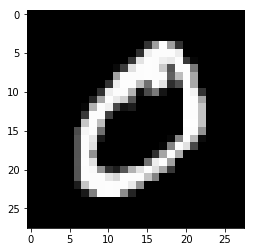

In [96]:
print('Train data shape = {s}'.format(s=train_data.train_data.shape))   # 60000 picture
print('Train label shape  = {s}\n\n'.format(s=train_data.train_labels.shape)) # 60000 labels

print('Test data shape = {s}'.format(s=test_data.test_data.shape))
print('Test data label shape = {s}\n'.format(s=test_data.test_labels.shape))

plt.imshow(train_data.train_data[1].numpy(),cmap='gray')
plt.show()

In [97]:
# Batch train, Input shape = (50,1,28,28) 
DataLoader = torch.utils.data.DataLoader(dataset=train_data,shuffle=True,batch_size=BatchSize)
print(type(DataLoader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [98]:
# More detail about Conv2d in https://pytorch.org/docs/stable/nn.html

class CNN(nn.Module):
    # Class_Num mean 0~9
    def __init__(self, Class_Num=10): 
        super(CNN,self).__init__()
        # nn.Conv2d(in, out, kernel_size, stride, padding)
        # out = filters number
        # in  = input height
        # kernel_size = n -> n*n kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1)
        self.n1 = nn.Linear(256, 60)
        self.n2 = nn.Linear(60, 84)
        self.n3 = nn.Linear(84, Class_Num)
    def forward(self, x)-> torch.tensor:
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.n1(x))
        x = F.relu(self.n2(x))
        x1 = self.n3(x)
        return x1
    # View every layer shape
    def TestFunction(self, x)-> torch.tensor:
        print('\n\n==== In the test function: ====')
        print('Input data size = {}'.format(x.shape))
        out = self.conv1(x)
        print('After Conv1:',out.shape)
        out = F.max_pool2d(F.relu(out), (2, 2))
        print('After Maxpooling 1 :',out.shape)
        out = self.conv2(out)
        print('After Conv2 : ',out.shape)
        out = F.max_pool2d(F.relu(out), (2, 2))
        print('After Maxpooling 2 :',out.shape)
        out = out.view(out.size()[0], -1)
        print('After Fitting',out.shape)
        out = F.relu(self.n1(out))
        print('After Linear N1 :',out.shape)
        out = F.relu(self.n2(out))
        print('After Linear N2 :',out.shape)
        out = self.n3(out)
        print('After Linear N3 :',out.shape)
        print('==== End of the test function ====\n\n')
        return out

In [99]:
Cnn = CNN()
print(Cnn)
for name, parameters in Cnn.named_parameters():
    print(name,':',parameters.shape)

testdata = torch.ones(50, 1, 28, 28)

# Use the TestFunction to watch every layer shape
test = Cnn.TestFunction(testdata)
print(type(test))
print(test.shape)
print(test[0])
print(test[1],'\n\n')

test2 = Cnn(testdata)
print(type(test2))
print(test2.shape)
print(test2)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (n1): Linear(in_features=256, out_features=60, bias=True)
  (n2): Linear(in_features=60, out_features=84, bias=True)
  (n3): Linear(in_features=84, out_features=10, bias=True)
)
conv1.weight : torch.Size([16, 1, 5, 5])
conv1.bias : torch.Size([16])
conv2.weight : torch.Size([16, 16, 5, 5])
conv2.bias : torch.Size([16])
n1.weight : torch.Size([60, 256])
n1.bias : torch.Size([60])
n2.weight : torch.Size([84, 60])
n2.bias : torch.Size([84])
n3.weight : torch.Size([10, 84])
n3.bias : torch.Size([10])


==== In the test function: ====
Input data size = torch.Size([50, 1, 28, 28])
After Conv1: torch.Size([50, 16, 24, 24])
After Maxpooling 1 : torch.Size([50, 16, 12, 12])
After Conv2 :  torch.Size([50, 16, 8, 8])
After Maxpooling 2 : torch.Size([50, 16, 4, 4])
After Fitting torch.Size([50, 256])
After Linear N1 : torch.Size([50, 60])
After Linear N2 : torch.Size([50,

In [100]:
# Set optimizer and loss function
Optimizer = torch.optim.Adam(Cnn.parameters(),lr=LearningRate)
Loss_func = torch.nn.CrossEntropyLoss()

In [101]:
# Train 
start = time.time()
for epoch in range(Epochs):
    for step, (x, y) in enumerate(DataLoader):
        Output = Cnn(x)
        #print(Output.shape)
        LossValue = Loss_func(Output, y)
        
        Optimizer.zero_grad()
        LossValue.backward()
        Optimizer.step()
        
        if (step+1)%50==0 or step==0:
            print('In Epoch {e}, Step {s} : Loss = {l}'.format(e=epoch+1, s=step+1, l=LossValue.item()))
end = time.time()
print('Result, Loss = {l}\nTotal time = {t}'.format(l=LossValue.item(), t=end-start))

In Epoch 1, Step 1 : Loss = 2.3041305541992188
In Epoch 1, Step 50 : Loss = 0.8391541838645935
In Epoch 1, Step 100 : Loss = 0.5008198022842407
In Epoch 1, Step 150 : Loss = 0.2859257757663727
In Epoch 1, Step 200 : Loss = 0.2903510332107544
In Epoch 1, Step 250 : Loss = 0.2500843405723572
In Epoch 1, Step 300 : Loss = 0.5445688366889954
In Epoch 1, Step 350 : Loss = 0.02414477802813053
In Epoch 1, Step 400 : Loss = 0.3303970992565155
In Epoch 1, Step 450 : Loss = 0.3636881709098816
In Epoch 1, Step 500 : Loss = 0.06154414266347885
In Epoch 1, Step 550 : Loss = 0.2082306444644928
In Epoch 1, Step 600 : Loss = 0.37433791160583496
In Epoch 1, Step 650 : Loss = 0.09910938143730164
In Epoch 1, Step 700 : Loss = 0.22424747049808502
In Epoch 1, Step 750 : Loss = 0.2493910938501358
In Epoch 1, Step 800 : Loss = 0.09095758199691772
In Epoch 1, Step 850 : Loss = 0.14179186522960663
In Epoch 1, Step 900 : Loss = 0.192717507481575
In Epoch 1, Step 950 : Loss = 0.1894713044166565
In Epoch 1, Step 

In [102]:
# Test data reshape
print(type(test_data))

print(test_data.test_data.shape)
#test_data.test_data = torch.squeeze(test_data.test_data, 0)
test_data.test_data = torch.unsqueeze(test_data.test_data, 1)
print(test_data.test_data.shape)
print(test_data.test_labels.shape)


<class 'torchvision.datasets.mnist.MNIST'>
torch.Size([10000, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [105]:
# Test 
test_data.test_data = test_data.test_data.float()
print('test data shape = ',test_data.test_data.shape)
Result = Cnn(test_data.test_data)
print('Output shape = ', Result.shape)

# How to use torch.max please see https://github.com/davidleitw/Pytorch_Learn/blob/master/4.Pytorch_CommonFunc/torch.max.ipynb
Predict = torch.max(Result, 1)[1]
print(Predict.shape)
print(test_data.test_labels.shape)
print('Total accuracy = {}%'.format(((Predict==test_data.test_labels).sum().item())/100))


test data shape =  torch.Size([10000, 1, 28, 28])
Output shape =  torch.Size([10000, 10])
torch.Size([10000])
torch.Size([10000])
Total accuracy = 91.42%


In [109]:
# Save the madel
torch.save(Cnn,'SampleCnn.pkl') 

C:\Users\Admin\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
